0.0766831679958584


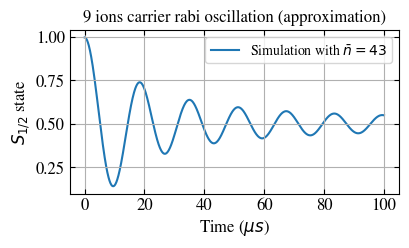

In [1]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 200
    for n in range(0, N):
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
    return res

t = np.linspace(0, 100, 1000)
plt.figure(figsize=(4.25, 4.25 / 2))
nbar_opt = 43
plt.plot(t, 1 - thermal_carrier(t, 1 / 16, nbar_opt), label=f'Simulation with $\\bar{{n}} = {nbar_opt}$', zorder=1)
plt.title('9 ions carrier rabi oscillation (approximation)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'$S_{1/2}$ state', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.legend()
plt.grid(True)
plt.show()

In [2]:
from qutip import *
from scipy.optimize import fsolve, leastsq,root,brentq,newton,curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

def Eqposition3(N):    
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=u[m]-np.sum(1/(u[m]-u[:m])**2)+np.sum(1/(u[m]-u[m+1:])**2)
        return p
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=1+2*np.sum(1/(u[m]-u[:m])**3)-2*np.sum(1/(u[m]-u[m+1:])**3)
        return p
    ni = np.arange(0,N)
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    x0=newton(func,guess,fprime=dfunc,maxiter=100000) # newton method
    return(np.round(x0,5))

def Axialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    u=Eqposition3(N)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    # return(np.sqrt(([w,v])[0])*wz) / 2

Axialfull(9, 0.18)

def Axialmodes(N, wz):
    return(np.sqrt(Axialfull(N, wz)[0])*wz)

#L-D parameter matrix in i，m
def eta_z(N, wz):
    A = Axialfull(N,wz)
    #print(A[1])
    eta = np.zeros((N,N))
    for i in range(N):
        eta[i] = 2*np.pi/(729e-9)*np.sqrt(1.0545718e-34/(2*40*1.66054e-27*2*np.pi*np.sqrt(A[0])*wz*1e6)) *  np.transpose(A[1])[:,i]
    #print(time()-t0)
    return eta

0.006033182144165039


In [3]:
N = 9
wz = 0.178
Axialmodes_1 = Axialmodes(N,wz) / 2
carrier_freq = 233.624
for i in range(len(Axialmodes_1)):
    print(f"BSB #{i} mode real AOM freq: ", carrier_freq - Axialmodes_1[i], "MHz")

print("")

for i in range(len(Axialmodes_1)):
    print(f"RSB #{i} mode real AOM freq: ", carrier_freq +Axialmodes_1[i], "MHz")

0.008446216583251953
BSB #0 mode real AOM freq:  233.535 MHz
BSB #1 mode real AOM freq:  233.46984754089905 MHz
BSB #2 mode real AOM freq:  233.40896485098978 MHz
BSB #3 mode real AOM freq:  233.3511872257002 MHz
BSB #4 mode real AOM freq:  233.29574464645654 MHz
BSB #5 mode real AOM freq:  233.2421074718405 MHz
BSB #6 mode real AOM freq:  233.18989889524028 MHz
BSB #7 mode real AOM freq:  233.13886479251076 MHz
BSB #8 mode real AOM freq:  233.08882945969782 MHz

RSB #0 mode real AOM freq:  233.713 MHz
RSB #1 mode real AOM freq:  233.77815245910094 MHz
RSB #2 mode real AOM freq:  233.83903514901021 MHz
RSB #3 mode real AOM freq:  233.8968127742998 MHz
RSB #4 mode real AOM freq:  233.95225535354345 MHz
RSB #5 mode real AOM freq:  234.00589252815948 MHz
RSB #6 mode real AOM freq:  234.05810110475971 MHz
RSB #7 mode real AOM freq:  234.10913520748923 MHz
RSB #8 mode real AOM freq:  234.15917054030217 MHz


<div align = "left">
    <img src="IMAGE_multiple_mode_rabi.png" style="zoom:80%">
    <br>
    <div align = "center"
          style=
           "color:orange;
            border-bottom: 1px solid #d9d9d9;
            display: inline-block;
            color: #999;
            padding: 2px;
            font-size: 15px"> Multi-ion carrier rabi </div>
</div>

In [4]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# Define a function to calculate equilibrium positions of N ions in a trap
def Eqposition3(N):    
    def func(u): # Equations for equilibrium positions
        p = np.empty(shape=(N))
        for m in range(N):
            p[m] = u[m] - np.sum(1/(u[m] - u[:m])**2) + np.sum(1/(u[m] - u[m+1:])**2)
        return p
    
    def dfunc(u): # Derivative of equilibrium equations for optimization
        p = np.empty(shape=(N))
        for m in range(N):
            p[m] = 1 + 2*np.sum(1/(u[m] - u[:m])**3) - 2*np.sum(1/(u[m] - u[m+1:])**3)
        return p
    
    ni = np.arange(0, N) # Initial guess for positions
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    x0 = newton(func, guess, fprime=dfunc, maxiter=100000) # Solve using Newton's method
    return np.round(x0, 5)

# Define a function to calculate the full matrix of axial mode frequencies and eigenvectors
def Axialfull(N, wz): 
    u = Eqposition3(N) # Get equilibrium positions
    u_1 = np.empty(shape=(N))
    for i in range(N): # Loop to calculate elements of the A matrix
        u_1[i] = np.sum(1/np.absolute(u[i] - u[:i])**3) + np.sum(1/np.absolute(u[i] - u[i+1:])**3)
    A = np.empty((N, N))
    for i in range(N): # Fill the A matrix with calculated values
        for j in range(N):
            if j == i:
                A[i, j] = 1 + 2*u_1[i] # Diagonal elements
            else:
                A[i, j] = -2/np.absolute(u[i] - u[j])**3 # Off-diagonal elements
    w, v = np.linalg.eig(A) # Calculate eigenvalues and eigenvectors
    idx = np.argsort(w) # Sort eigenvalues and corresponding eigenvectors
    w = w[idx]
    v = v[:, idx]
    return [w, v]
    
# Calculate axial modes frequencies based on the full matrix calculation
def Axialmodes(N, wz):
    return np.sqrt(Axialfull(N, wz)[0])*wz

# Function to calculate L-D parameter matrix for N ions and axial frequency wz
def eta_z(N, wz):
    hbar = 1.0545718e-34 # Planck's constant over 2*pi
    m_ca = 1.67*10**(-27) * 40 # Mass of Ca ion
    A = Axialfull(N, wz) # Get full axial matrix
    eta = np.zeros((N, N)) # Initialize eta matrix
    for i in range(N): # Calculate eta values
        eta[i] = 2*np.pi/(729e-9)*np.sqrt(hbar/(2*m_ca*2*np.pi*np.sqrt(A[0])*wz*1e6)) * np.transpose(A[1])[:, i]
    return eta

N = 9 # Number of ions
wz = 0.177 # Axial frequency in MHz
eta = eta_z(N, wz) # Calculate L-D parameters

# Set constants and initial conditions for the simulation
m_ca = 1.67*10**(-27) * 40 # Mass of Ca ion
Z = 1 # Charge of the ion
e = 1.6*10**(-19) # Charge of an electron
epsilon = 8.85*10**(-12) # Vacuum permittivity
l = np.power((Z**3*e**2/(4*np.pi*epsilon*m_ca*(wz*2*np.pi*10**6)**2)), 1/3)*10**6 # Characteristic length

Axialmodes_1 = Axialmodes(N, wz) # Calculate axial modes
M = 16 # Number of phonon states considered
nbar = 10 # Average number of phonons
Population = np.zeros((N, M)) # Initialize phonon state population matrix
mean_phonon = np.zeros(N) # Mean phonon number for each mode
# Assume nbar limited by cooling/heating, proportional to mode frequency
for i in range(5): # Calculate mean phonon numbers
    if i == 0:
        mean_phonon[i] = nbar
    else:
        mean_phonon[i] = mean_phonon[0]*Axialmodes_1[0]/Axialmodes_1[i]

for i in range(N): # Calculate phonon state population for each mode
    for j in range(M):
        Population[i, j] = (mean_phonon[i])**j/((mean_phonon[i]+1)**(j+1))

coupling_1 = np.zeros(N) # Coupling coefficients for each ion
for i in range(N): # Calculate coupling coefficients
    coupling_1[i] = np.prod(np.exp(-eta[i, :]**2/2))

# Pre-calculate all the special functions needed for the simulation
eta_2 = eta**2
laguerre_fun = np.zeros((M, 24, 24))
for m in range(M):
    for j in range(N):
        for k in range(N):
            laguerre_fun[m, j, k] = laguerre(m)(eta_2[j, k])

intensity_distribution = np.ones(N) # Assume uniform intensity distribution across ions

def P_i(t, I):
    # Calculate the Rabi frequencies modified by coupling and intensity distribution once for each ion
    modified_Rabi = 1 / 5.05 * coupling_1[I] * intensity_distribution[I]
    
    # Pre-compute the product of Laguerre polynomials for all combinations of phonon states
    laguerre_products = np.ones((M, M, M, M, M))
    for m_1 in range(M):
        for m_2 in range(M):
            for m_3 in range(M):
                for m_4 in range(M):
                    for m_5 in range(M):
                        laguerre_products[m_1, m_2, m_3, m_4, m_5] = laguerre_fun[m_1][I][0] * laguerre_fun[m_2][I][1] * laguerre_fun[m_3][I][2] * laguerre_fun[m_4][I][3] * laguerre_fun[m_5][I][4]
    
    # Compute the final Rabi frequencies considering Laguerre polynomial products
    final_Rabi = modified_Rabi * laguerre_products
    
    # Calculate the population product for all combinations of phonon states
    population_products = np.outer(np.outer(np.outer(np.outer(Population[0], Population[1]), Population[2]), Population[3]), Population[4]).reshape(M, M, M, M, M)
    
    # Calculate probability matrix using vectorized operations
    P = population_products * np.cos(final_Rabi * t)**2
    
    return np.sum(P)

# Simulation parameters
times = np.linspace(0, 100, 200) # Time array for simulation
time_evo = np.zeros((N, len(times))) # Initialize array for time evolution data

# Calculate time evolution of ground state probability for each ion
for n in range(N):
    for i, time in enumerate(times):
        time_evo[n, i] = P_i(time, n)

# # Plot the time evolution of ground state probability
# fig, ax = plt.subplots()
# for i in range(N):
#     ax.plot(times, time_evo[i], label=f"Spin {i+1}")
# plt.title("Spin up population at ground state")
# plt.xlabel("Time")
# plt.legend()
# plt.show()

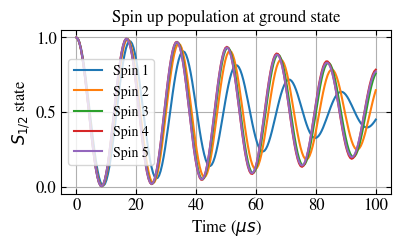

0.0766831679958584


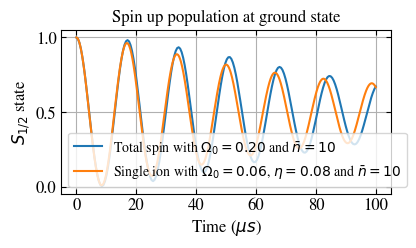

In [5]:
import h5py as h5
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
import scipy as sc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit

# Setting matplotlib style parameters
matplotlib.rcParams.update({
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "xtick.direction": "in",
    "xtick.major.pad": 3,
    "xtick.top": True,
    "ytick.labelsize": 12,
    "ytick.direction": "in",
    "ytick.right": True,
    "axes.labelsize": 12,
    "axes.labelpad": 3,
    "axes.grid": True
})

# Initialize the figure with a specific size and aspect ratio
half_column_width_inches = 4.25
aspect_ratio = 2
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# Example plotting commands (commented out since `rabi_t`, `pmt_counts_avg_thresholded`, `errorbar`, `t_fine`, and `fitted_curve` are undefined in your snippet)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded, yerr=errorbar, fmt='o', c='black', lw=0.5, markersize=4, zorder=2, label=r'Raw Data')  # Adjust markersize as needed
# plt.plot(t_fine, fitted_curve, 'C0', zorder = 1, label='Fitted Curve')
# Plot the time evolution of ground state probability for N spins
for i in range(N):
    if(i < 5):
        plt.plot(times, time_evo[i] / np.max(time_evo[i]), label=f"Spin {i+1}")
# Setting title, labels, and legend with specific font settings
plt.title('Spin up population at ground state', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'$S_{1/2}$ state', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.ylabel(r'$D_{5/2}$ state probability', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.legend()
# Enabling grid
plt.grid(True)
# Save the figure with tight bounding box
plt.savefig('Spin_up_population_at_ground_state.pdf', format='pdf', bbox_inches='tight')
# Display the plot
plt.show()

# Initialize the figure with a specific size and aspect ratio
half_column_width_inches = 4.25
aspect_ratio = 2
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
time_evo_in_total = np.zeros(len(times))
for i in range(N):
    time_evo_in_total += time_evo[i]
plt.plot(times, time_evo_in_total / np.max(time_evo_in_total), color = "C0", label=f"Total spin with $\Omega_{0} = {1/5.05:.2f}$ and $\\bar{{n}} = {nbar}$")

s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / 3
print(η)
t = np.linspace(0, 100, 1000)
def fit_function(times, a, b, c, nbar):
    return a * thermal_carrier(times, b, nbar) + c
b = 1 / 16
# b = 1 / (5.05 * 3)
plt.plot(t, 1 - fit_function(t, 1, b, 0, 10), color = "C1", label=f"Single ion with $\Omega_{0} = {b:.2f}$, $\eta = {η:.2f}$ and $\\bar{{n}} = {nbar}$")
# plt.plot(t, 1 - fit_function(t, 1, 1/16, 0, 10), color = "C1", label=f"Sinmulation with single ion $\eta = {η:.2f}$")

# Setting title, labels, and legend with specific font settings
plt.title('Spin up population at ground state', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'$S_{1/2}$ state', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.ylabel(r'$D_{5/2}$ state probability', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.legend()
# Enabling grid
plt.grid(True)
# Save the figure with tight bounding box
plt.savefig('Spin_up_population_at_ground_state_total.pdf', format='pdf', bbox_inches='tight')
# Display the plot
plt.show()

['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


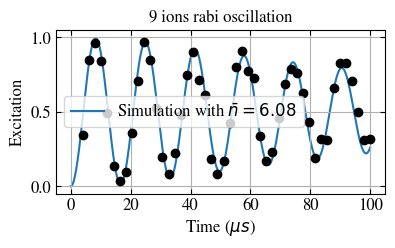

In [6]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_samples = 50

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240214/results/"
date = "2024-03-07/"
number = 7497
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())

print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)

pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Plotting
nbar = 6.076080795652779
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.title('9 ions rabi oscillation', fontdict={'family': 'STIXGeneral', 'size': 12})
# Plot the smooth curve with a higher zorder to ensure it's on top
# plt.plot(rabi_t, pmt_counts_avg_thresholded, c='C0', lw=2, zorder=1, label='Smoothed Curve')
pmt_counts_avg_thresholded_renew = pmt_counts_avg_thresholded[2:]
plt.errorbar(rabi_t[2:], (pmt_counts_avg_thresholded_renew - 0.14595767082374253) * (1/0.8809862132150643), yerr=errorbar[2:], fmt='o', c='black', lw=1, zorder=2)
# plt.plot(times, scaled_array, zorder=0)
times = np.linspace(0,100,500)
plt.plot(times, thermal_carrier(times, 0.0622167267179297, nbar), zorder=1, label = f'Simulation with $\\bar{{n}} = {nbar:.2f}$')
# Scatter plot of the original data
# plt.scatter(rabi_t, pmt_counts_avg_thresholded, c='black', s=10, lw=1, zorder=2)
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.grid(True)
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
pdf_filename = 'Rabi_9_ions.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

0.0766831679958584
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 0.8746129787341189, b = 0.062794562906589, c = 0.14783338177001276, nbar = 5.231787854596411
Optimal parameters with their standard errors:
a = 0.8746129787341189 ± 0.047491474611936854
b = 0.062794562906589 ± 0.0002520133365431911
c = 0.14783338177001276 ± 0.025251734978180188
nbar = 5.231787854596411 ± 0.9944125064161446


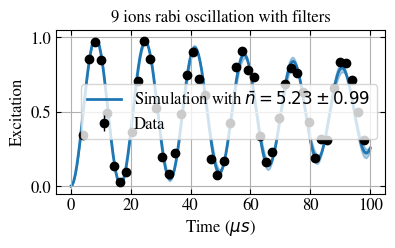

In [7]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 200
    for n in range(0, N):
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
    return res

# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-15/"
# number = 8591
# file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240214/results/"
date = "2024-03-07/"
number = 7497
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
times = np.linspace(0, 100, 200) # Time array for simulation

# /Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-1]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-1]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))
intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
def fit_function(times, a, b, c, nbar):
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0622167267179297, 0.14595767082374253, 6]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 6.076080795652779
# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 2
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_v2.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

In [8]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

def fit_function(times, a, b, c, nbar):
    return a * thermal_carrier(times, b, nbar) + c

# Define your fitting function parameters
initial_guess = [1, 0.062, 0.1, 7]  # Example initial guesses for a, b, c, and nbar

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)

# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt

print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")

# # Plotting the data and the fit
# plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.title('9 ions rabi oscillation', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
# legend_fontsize = 12
# plt.legend(fontsize=legend_fontsize)
# plt.grid(True)
# # pdf_filename = 'Rabi_9_ions.pdf'
# # plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
# plt.show()

Optimal parameters: a = 0.8748082396338182, b = 0.06214954439763648, c = 0.1478999892518834, nbar = 5.821031342904066


### with 300 us wait time

0.0766831679958584
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 1.1596274537560862, b = 0.02334033070639091, c = -0.03603551642667138, nbar = 41.1067232102636
Optimal parameters with their standard errors:
a = 1.1596274537560862 ± 0.08036730379538339
b = 0.02334033070639091 ± 0.00018653675197359567
c = -0.03603551642667138 ± 0.040836810055157886
nbar = 41.1067232102636 ± 4.650731943905143


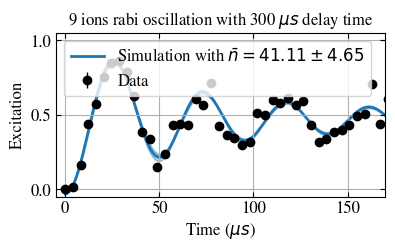

In [9]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 500
    for n in range(0, N):
        # res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * (n + 0.5) + η**4 * ((1/8) * (1 + 2 * n * (1 + n)))) * (time - t0)) / (2 * (n̄ + 1))
    return res

# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-15/"
# number = 8591
# file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8652
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
times = np.linspace(0, 200, 200) # Time array for simulation

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))
intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
def fit_function(times, a, b, c, nbar):
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# Define your fitting function parameters
initial_guess = [1, 0.03, 0.1, 20]  # Example initial guesses for a, b, c, and nbar
# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, *popt[:3], nbar_opt - nbar_err) / a_opt
fit_upper_bound = fit_function(times, *popt[:3], nbar_opt + nbar_err) / a_opt

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with 300 $\mu$$s$ delay time', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.xlim(-5, 170)
pdf_filename = 'Rabi_9_ions_without_filter_and_with_AWG_repeat_no_shuttling_300us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

Optimal parameters with their standard errors:
a = 1.1596274537560862 ± 0.08036730379538339
b = 0.02334033070639091 ± 0.00018653675197359567
c = -0.03603551642667138 ± 0.040836810055157886
nbar = 41.1067232102636 ± 4.650731943905143


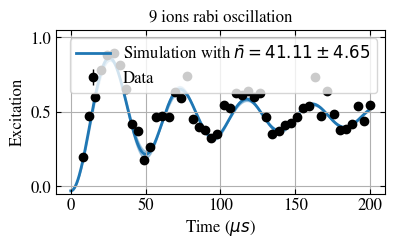

In [10]:
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
times = np.linspace(0,200,500)
fit_lower_bound = fit_function(times, *popt[:3], nbar_opt - nbar_err) / a_opt
fit_upper_bound = fit_function(times, *popt[:3], nbar_opt + nbar_err) / a_opt

# Plotting
nbar = nbar_opt
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.title('9 ions rabi oscillation', fontdict={'family': 'STIXGeneral', 'size': 12})
# Plot the smooth curve with a higher zorder to ensure it's on top
# plt.plot(rabi_t, pmt_counts_avg_thresholded, c='C0', lw=2, zorder=1, label='Smoothed Curve')
pmt_counts_avg_thresholded_renew = pmt_counts_avg_thresholded[2:]
plt.errorbar(rabi_t[2:], (pmt_counts_avg_thresholded_renew - c_opt) * (1/a_opt), yerr=errorbar[2:], fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, scaled_array, zorder=0)
# plt.plot(times, fit_function(times, 1, b_opt, 0, nbar), zorder=1, lw=2, label = f'Simulation with $\\bar{{n}} = {nbar:.2f}$')
plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# Scatter plot of the original data
# plt.scatter(rabi_t, pmt_counts_avg_thresholded, c='black', s=10, lw=1, zorder=2)
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.grid(True)
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
# pdf_filename = 'Rabi_9_ions_without_filter_and_with_AWG_repeat.pdf'
# plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

### 9 ion flopping without shuttling

0.0766831679958584
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 0.9437525027029401, b = 0.019531803970010052, c = 0.10928143419717275, nbar = 28.647854952627178
Optimal parameters with their standard errors:
a = 0.9437525027029401 ± 0.10223206171236525
b = 0.019531803970010052 ± 0.0002860164843889301
c = 0.10928143419717275 ± 0.052824027944253525
nbar = 28.647854952627178 ± 5.86648846202098


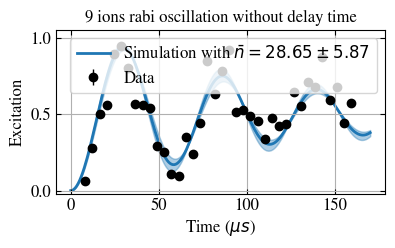

In [11]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 500
    for n in range(0, N):
        # res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * (n + 0.5) + η**4 * ((1/8) * (1 + 2 * n * (1 + n)))) * (time - t0)) / (2 * (n̄ + 1))
    return res

# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-15/"
# number = 8591
# file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-15/"
number = 8591
file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
times = np.linspace(0, 170, 200) # Time array for simulation

# /Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-10]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-10]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))
intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
def fit_function(times, a, b, c, nbar):
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# Define your fitting function parameters
initial_guess = [1, 0.04, 0.1, 20]  # Example initial guesses for a, b, c, and nbar
# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 2
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation without delay time', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.02, 1.05)
pdf_filename = 'Rabi_9_ions_without_filter_and_with_AWG_repeat_no_shuttling_no_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

### with 300 us wait time

0.0766831679958584
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 1.1697156916466431, b = 0.023471568881785948, c = -0.04333616722569373, nbar = 43.00784288745962
Optimal parameters with their standard errors:
a = 1.1697156916466431 ± 0.07608563026516037
b = 0.023471568881785948 ± 0.0002104972315615569
c = -0.04333616722569373 ± 0.03865783706535982
nbar = 43.00784288745962 ± 4.6608933463224655


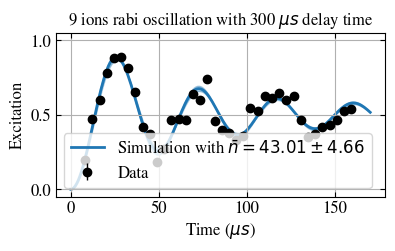

In [12]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 500
    for n in range(0, N):
        # res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * (n + 0.5) + η**4 * ((1/8) * (1 + 2 * n * (1 + n)))) * (time - t0)) / (2 * (n̄ + 1))
    return res

# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-15/"
# number = 8591
# file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8652
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
times = np.linspace(0, 170, 200) # Time array for simulation

# /Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-10]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-10]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))
intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
def fit_function(times, a, b, c, nbar):
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# Define your fitting function parameters
initial_guess = [1, 0.03, 0.1, 20]  # Example initial guesses for a, b, c, and nbar
# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 2
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with 300 $\mu$$s$ delay time', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_without_filter_and_with_AWG_repeat_no_shuttling_300us_delay_v2.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

### with 500 us wait time

0.0766831679958584
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 0.9148293193394383, b = 0.0222136998497034, c = -0.015607656609398186, nbar = 51.222917772566994
Optimal parameters with their standard errors:
a = 0.9148293193394383 ± 0.07544576830151813
b = 0.0222136998497034 ± 0.0002766591830801581
c = -0.015607656609398186 ± 0.037338484236563024
nbar = 51.222917772566994 ± 6.831408173740202


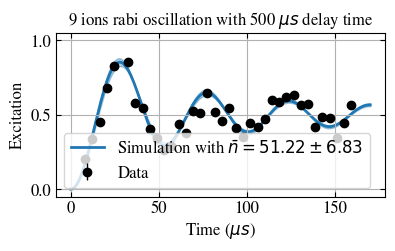

In [13]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 500
    for n in range(0, N):
        # res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * (n + 0.5) + η**4 * ((1/8) * (1 + 2 * n * (1 + n)))) * (time - t0)) / (2 * (n̄ + 1))
    return res

# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-15/"
# number = 8591
# file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8662
file_path = data_path + date + f"01/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
times = np.linspace(0, 170, 200) # Time array for simulation

# /Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-10]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-10]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))
intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
def fit_function(times, a, b, c, nbar):
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# Define your fitting function parameters
initial_guess = [1, 0.03, 0.1, 20]  # Example initial guesses for a, b, c, and nbar
# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 2
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with 500 $\mu$$s$ delay time', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_without_filter_and_with_AWG_repeat_no_shuttling_500us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

### with 1 ms wait time

0.0766831679958584
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 0.8248808283686755, b = 0.020634984102409507, c = 0.14793724478599574, nbar = 52.64979628493957
Optimal parameters with their standard errors:
a = 0.8248808283686755 ± 0.12151650556375053
b = 0.020634984102409507 ± 0.0004930209620433412
c = 0.14793724478599574 ± 0.059475617903702815
nbar = 52.64979628493957 ± 12.553180692564956


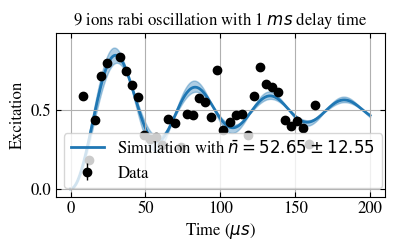

In [14]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, Ω, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 500
    for n in range(0, N):
        # res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * Ω * (1 - η**2 * (n + 0.5) + η**4 * ((1/8) * (1 + 2 * n * (1 + n)))) * (time - t0)) / (2 * (n̄ + 1))
    return res

def fit_function(times, a, b, c, nbar):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# File loading
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):    
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)

n_samples = 50
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
index = "01"
number = 8666
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = rabi_t[:-9]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[:-9]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Data fitting
initial_guess = [1, 0.01, 0.1, 0]  # Example initial guesses for a, b, c, and nbar
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
perr = np.sqrt(np.diag(pcov))
a_err, b_err, c_err, nbar_err = perr
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
number_drop = 2
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with 1 $m$$s$ delay time', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 0.99)
pdf_filename = 'Rabi_9_ions_without_filter_and_with_AWG_repeat_no_shuttling_1000us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

### Heating rate

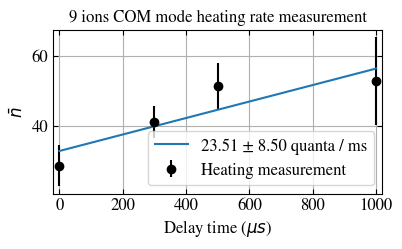

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Provided data
delay_time = np.array([0, 300, 500, 1000])  # Delay times
nbar_list = np.array([28.65, 41.11, 51.22, 52.65])  # Corresponding nbar values
nbar_errorbar = np.array([5.87, 4.65, 6.83, 12.55])  # Error bars for nbar
# Perform linear fit with covariance matrix to get the errors of the fit parameters
fit_coefficients, cov_matrix = np.polyfit(delay_time, nbar_list, 1, cov=True)  # '1' for linear fit
fit_function = np.poly1d(fit_coefficients)
# Standard errors of the fit parameters
std_errors = np.sqrt(np.diag(cov_matrix))
slope_error = std_errors[0]
# Create a range of delay times for plotting the fit
fit_delay_time = np.linspace(min(delay_time), max(delay_time), 500)
fit_nbar = fit_function(fit_delay_time)
# Calculate the upper and lower bounds of the fit considering the error in the slope
fit_nbar_upper = np.poly1d([fit_coefficients[0] + slope_error, fit_coefficients[1]])(fit_delay_time)
fit_nbar_lower = np.poly1d([fit_coefficients[0] - slope_error, fit_coefficients[1]])(fit_delay_time)

# Provided data
delay_time_new = np.array([0, 300, 500])  # Delay times
nbar_list_new = np.array([28.65, 41.11, 51.22])  # Corresponding nbar values
nbar_errorbar_new = np.array([5.87, 4.65, 6.83])  # Error bars for nbar
# Perform linear fit with covariance matrix to get the errors of the fit parameters
fit_coefficients_new, cov_matrix_new = np.polyfit(delay_time_new, nbar_list_new, 1, cov=True)  # '1' for linear fit
fit_function_new = np.poly1d(fit_coefficients_new)
# Standard errors of the fit parameters
std_errors_new = np.sqrt(np.diag(cov_matrix_new))
slope_error_new = std_errors_new[0]
# Create a range of delay times for plotting the fit
fit_delay_time_new = np.linspace(min(delay_time_new), max(delay_time_new), 500)
fit_nbar_new = fit_function_new(fit_delay_time_new)
# Calculate the upper and lower bounds of the fit considering the error in the slope
fit_nbar_upper_new = np.poly1d([fit_coefficients[0] + slope_error, fit_coefficients[1]])(fit_delay_time_new)
fit_nbar_lower_new = np.poly1d([fit_coefficients[0] - slope_error, fit_coefficients[1]])(fit_delay_time_new)

# Plotting the data and the fit
plt.figure(figsize=(4.25, 4.25 / 2))
plt.errorbar(delay_time, nbar_list, yerr=nbar_errorbar, fmt='o', c='black', label='Heating measurement')
plt.plot(fit_delay_time, fit_nbar, '-', label=f'{fit_coefficients[0] * 1000:.2f} ± {slope_error * 1000:.2f} quanta / ms')
# plt.plot(fit_delay_time_new, fit_nbar_new, '-', label=f'{fit_coefficients_new[0] * 1000:.2f} ± {slope_error_new * 1000:.2f} quanta / ms')
# plt.fill_between(fit_delay_time, fit_nbar_lower, fit_nbar_upper, color='grey', alpha=0.2, label='Fit uncertainty')
plt.title(r'9 ions COM mode heating rate measurement', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Delay time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(f"$\\bar{{n}}$", fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlim(-20, 1020)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True)
plt.savefig('Rabi_9_ions_heating_rate_measurement_linear_fit_with_uncertainty_v3.pdf', format='pdf', bbox_inches='tight')
plt.show()

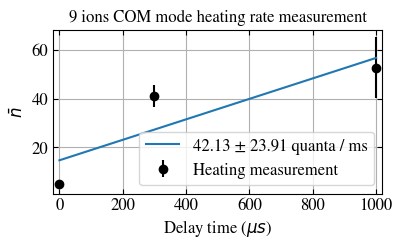

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Provided data
delay_time = np.array([0, 300, 1000])  # Delay times
nbar_list = np.array([5, 41.11, 52.65])  # Corresponding nbar values
nbar_errorbar = np.array([1, 4.65, 12.55])  # Error bars for nbar
# Perform linear fit with covariance matrix to get the errors of the fit parameters
fit_coefficients, cov_matrix = np.polyfit(delay_time, nbar_list, 1, cov=True)  # '1' for linear fit
fit_function = np.poly1d(fit_coefficients)
# Standard errors of the fit parameters
std_errors = np.sqrt(np.diag(cov_matrix))
slope_error = std_errors[0]
# Create a range of delay times for plotting the fit
fit_delay_time = np.linspace(min(delay_time), max(delay_time), 500)
fit_nbar = fit_function(fit_delay_time)
# Calculate the upper and lower bounds of the fit considering the error in the slope
fit_nbar_upper = np.poly1d([fit_coefficients[0] + slope_error, fit_coefficients[1]])(fit_delay_time)
fit_nbar_lower = np.poly1d([fit_coefficients[0] - slope_error, fit_coefficients[1]])(fit_delay_time)

# Provided data
delay_time_new = np.array([0, 300, 500])  # Delay times
nbar_list_new = np.array([28.65, 41.11, 51.22])  # Corresponding nbar values
nbar_errorbar_new = np.array([5.87, 4.65, 6.83])  # Error bars for nbar
# Perform linear fit with covariance matrix to get the errors of the fit parameters
fit_coefficients_new, cov_matrix_new = np.polyfit(delay_time_new, nbar_list_new, 1, cov=True)  # '1' for linear fit
fit_function_new = np.poly1d(fit_coefficients_new)
# Standard errors of the fit parameters
std_errors_new = np.sqrt(np.diag(cov_matrix_new))
slope_error_new = std_errors_new[0]
# Create a range of delay times for plotting the fit
fit_delay_time_new = np.linspace(min(delay_time_new), max(delay_time_new), 500)
fit_nbar_new = fit_function_new(fit_delay_time_new)
# Calculate the upper and lower bounds of the fit considering the error in the slope
fit_nbar_upper_new = np.poly1d([fit_coefficients[0] + slope_error, fit_coefficients[1]])(fit_delay_time_new)
fit_nbar_lower_new = np.poly1d([fit_coefficients[0] - slope_error, fit_coefficients[1]])(fit_delay_time_new)

# Plotting the data and the fit
plt.figure(figsize=(4.25, 4.25 / 2))
plt.errorbar(delay_time, nbar_list, yerr=nbar_errorbar, fmt='o', c='black', label='Heating measurement')
plt.plot(fit_delay_time, fit_nbar, '-', label=f'{fit_coefficients[0] * 1000:.2f} ± {slope_error * 1000:.2f} quanta / ms')
# plt.plot(fit_delay_time_new, fit_nbar_new, '-', label=f'{fit_coefficients_new[0] * 1000:.2f} ± {slope_error_new * 1000:.2f} quanta / ms')
# plt.fill_between(fit_delay_time, fit_nbar_lower, fit_nbar_upper, color='grey', alpha=0.2, label='Fit uncertainty')
plt.title(r'9 ions COM mode heating rate measurement', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Delay time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(f"$\\bar{{n}}$", fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlim(-20, 1020)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True)
plt.savefig('Rabi_9_ions_heating_rate_measurement_linear_fit_with_uncertainty_v3.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Coherent heating simulation - Half speed

In [17]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

# # For 1 ms data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "01"
# number = 8666

# For shuttled data
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
index = "01"
number = 8663

# # For shuttled data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "00"
# number = 8658

# File loading
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
indices_to_remove = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -18, -22]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded))) / 1.05 - 0.15    # / 0.58 - 0.28

# Running simulation
rabi = 0.055
n_ions = 7
N = 500
nbar = 4
nalpha = 60
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nalpha_values = [45, 50, 55]
results = []

for nalpha in nalpha_values:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, ndisplace_fit=complex(0, np.sqrt(nalpha)))
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_half_speed.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_half_speed.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_half_speed_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_half_speed_simulation.npy", results)

['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value en

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_2502/1008437697.py:8: RuntimeWarning: invalid value encountered in sqrt
  errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)


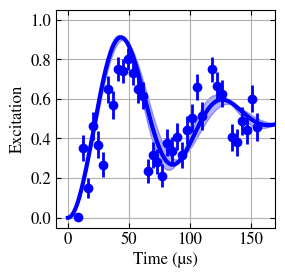

In [18]:
rabi_t = np.load("./data/save_rabi_t_shuttling_half_speed.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_half_speed.npy")
time = np.load("./data/save_rabi_t_shuttling_half_speed_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_half_speed_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[1:], pmt_counts_avg_thresholded[1:], yerr=errorbar[1:], fmt='o', c='blue', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='blue', s=30, zorder=2, label='Data')
plt.plot(time, results[1], c='blue', lw=3, zorder=3, label=f'$\\bar{{n}}_{{α}} = {np.average(nalpha_values):.1f} \\pm {(np.average(nalpha_values) - nalpha_values[0]):.1f}$')
plt.plot(time, results[0], '--', c='blue', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='blue', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='blue', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend()
plt.grid(True)
plt.savefig('Rabi_9_ions_half_speed_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Coherent heating simulation - Static

In [19]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

# # For 1 ms data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "01"
# number = 8666

# # For shuttled data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "01"
# number = 8663

# For shuttled data
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-15/"
index = "23"
number = 8591

# File loading
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
indices_to_remove = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -18, -22, 0]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices] - 5
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded))) / 0.95 - 0.08    # / 0.58 - 0.28

# Running simulation
rabi = 0.060
n_ions = 9
N = 500
nbar = 4
nalpha = 0
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, ndisplace_fit=complex(0, np.sqrt(nalpha)))
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value encountered in divide
  dy /= np.exp((log_dy.max() + log_dy.min()) / 2.)
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:193: RuntimeWarning: divide by zero encountered in divide
  w = 1.0 / (fm * dy)


/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_2502/1489434910.py:8: RuntimeWarning: invalid value encountered in sqrt
  errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)


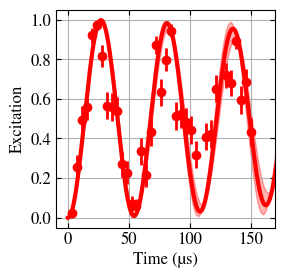

In [20]:
rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Coherent heating simulation - Full speed

In [21]:
from qutip import *
from scipy.optimize import fsolve, leastsq,root,brentq,newton,curve_fit
from scipy.special import laguerre
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 

N = 250
M = 100
nbar_N = 5
nbar_M = 0
eta_m = 0.23 * np.array([0.00423397, -0.05020945,  0.2195255, -0.49393711, 0.64077417, -0.49393711,  0.2195255, -0.05020945, 0.00423397])
eta_n = 0.23 * np.array([0.33333333] * 9)

def coherent_heating(nalpha, nbeta):
    # Assuming displace and tensor functions return QuTiP Qobj objects
    return tensor(displace(N, np.sqrt(nalpha)), displace(M, np.sqrt(nbeta)))

# Create thermal states for N and M
thermal_state_N = thermal_dm(N, nbar_N)
thermal_state_M = thermal_dm(M, nbar_M)

# Create the input state by applying coherent heating before and after the thermal states
inputstate = coherent_heating(65,50) * tensor(thermal_state_N, thermal_state_M) * coherent_heating(65,50).dag()

# Calculate the population
population = np.tensordot(np.abs(np.diagonal(ptrace(inputstate, 0).full())), np.abs(np.diagonal(ptrace(inputstate, 1).full())), axes=0)

time = np.linspace(0, 13, 100)
pe = np.zeros_like(time)

for n in range(N):
    for m in range(M):
        # Calculate Laguerre polynomials for eta_m and eta_n
        lag_m = laguerre(m)(eta_m**2)
        lag_n = laguerre(n)(eta_n**2)
        
        # Transpose or reshape the Laguerre polynomial arrays
        lag_m = lag_m.T  # Transpose or reshape as needed
        lag_n = lag_n.T  # Transpose or reshape as needed
        
        # Calculate the contribution to pe for the current n and m
        contribution = np.abs(population[n, m]) * np.sin(lag_m * lag_n * time[:, np.newaxis])**2
        
        # Accumulate the contribution
        pe += contribution.sum(axis=1)

# Divide by 9 outside of the loops
pe /= 9

laguerre(0)(eta_m[0]**2)*laguerre(0)(eta_n[0]**2)

# plt.plot(np.abs(np.diagonal(inputstate)))
# plt.plot(np.diagonal(coherent_dm(N, np.sqrt(60))*coherent_dm(N, np.sqrt(60)).dag()))

np.sum(np.diagonal(coherent_dm(N, np.sqrt(60))*coherent_dm(N, np.sqrt(60)).dag()))

# data = np.load("./data/pmt_counts_avg_thresholded_shuttling_half_speed_500us_delay.npy")
# data = np.load("./data/pmt_counts_avg_thresholded_no_shuttling_half_speed_0us_delay.npy")
data = np.load("./data/pmt_counts_avg_thresholded_shuttling_full_speed.npy")
time_data = np.linspace(0,12,50)

# plt.plot(time_data[:40],(1-(data[:40]-350)/50-0.25)/1.2,"bo")
# plt.plot(time[:80],pe[:80],"r")

np.save("./data/save_rabi_t_shuttling_full_speed_1.npy", time_data)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_1.npy", data)
np.save("./data/save_rabi_t_shuttling_full_speed_simulation_1.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_1.npy", pe)

/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


In [22]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

# For shuttled data
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-14/"
index = "02"
number = 8510

# File loading
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
indices_to_remove = []
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded))) / 1.1    # / 0.58 - 0.28

# Running simulation
rabi = 0.055
n_ions = 7
N = 500
nbar = 4
nalpha = 60
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nalpha_values = [105, 110, 115]
results = []

for nalpha in nalpha_values:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, ndisplace_fit=complex(0, np.sqrt(nalpha)))
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_full_speed_2.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_2.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_full_speed_simulation_2.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_2.npy", results)

# np.save("./data/save_rabi_t_shuttling_full_speed_2.npy", time_data)
# np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_2.npy", data)
# np.save("./data/save_rabi_t_shuttling_full_speed_simulation_2.npy", time)
# np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_2.npy", pe_old)

['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value encountered in divide
  dy /= np.exp((log_dy.max() + log_dy.min()) / 2.)
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:193: RuntimeWarning: divide by zero encountered in divide
  w = 1.0 / (fm * dy)


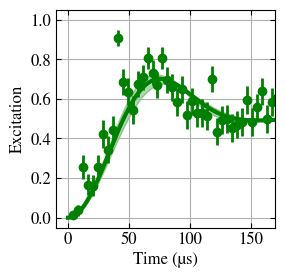

In [23]:
rabi_t = np.load("./data/save_rabi_t_shuttling_full_speed_2.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_2.npy")
time = np.load("./data/save_rabi_t_shuttling_full_speed_simulation_2.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_2.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[1:], pmt_counts_avg_thresholded[1:], yerr=errorbar[1:], fmt='o', c='green', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='green', s=30, zorder=2, label='Data')
plt.plot(time, results[1], c='green', lw=3, zorder=3, label=f'$\\bar{{n}}_{{α}} = {np.average(nalpha_values):.1f} \\pm {(np.average(nalpha_values) - nalpha_values[0]):.1f}$')
plt.plot(time, results[0], '--', c='green', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='green', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='green', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend()
plt.grid(True)
plt.savefig('Rabi_9_ions_full_speed_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value en

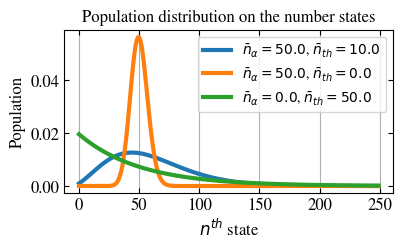

In [24]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = rabi_t[:]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[:]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded))) / 0.9    # / 0.58 - 0.28

# Running simulation
plt.figure(figsize=(4.25, 4.25 / 2))
rabi = 0.06
n_ions = 9
N = 500
nbar = 10
nalpha = 50
time = np.linspace(np.min(times), np.max(times), 50)
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
D_population_1, state_populations_1 = pe_model_optimized(time)
state_populations_1 = state_populations_1[:-int(N/2)]
plt.plot(range(len(state_populations_1)), state_populations_1, color='C0', lw = 3, label=f'$\\bar{{n}}_{{\\alpha}} = {nalpha:.1f}$, $\\bar{{n}}_{{th}} = {nbar:.1f}$')

rabi = 0.06
n_ions = 9
N = 500
nbar = 0
nalpha = 50
time = np.linspace(np.min(times), np.max(times), 50)
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
D_population_2, state_populations_2 = pe_model_optimized(time)
state_populations_2 = state_populations_2[:-int(N/2)]
plt.plot(range(len(state_populations_2)), state_populations_2, color='C1', lw = 3, label=f'$\\bar{{n}}_{{\\alpha}} = {nalpha:.1f}$, $\\bar{{n}}_{{th}} = {nbar:.1f}$')

rabi = 0.06
n_ions = 9
N = 500
nbar = 50
nalpha = 0
time = np.linspace(np.min(times), np.max(times), 50)
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
D_population_3, state_populations_3 = pe_model_optimized(time)
state_populations_3 = state_populations_3[:-int(N/2)]
plt.plot(range(len(state_populations_3)), state_populations_3, color='C2', lw = 3, label=f'$\\bar{{n}}_{{\\alpha}} = {nalpha:.1f}$, $\\bar{{n}}_{{th}} = {nbar:.1f}$')

plt.title('Population distribution on the number states', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel('${n}^{{th}}$ state', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Population', fontdict={'family': 'STIXGeneral', 'size':12})
plt.grid(axis='y')
plt.legend()
plt.savefig('Number_state_simulation.pdf', format='pdf', bbox_inches='tight')
plt.show()

# print(np.sum(state_populations))

In [25]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# Running simulation
rabi = 0.060
n_ions = 9
N = 500
nbar = 4
nalpha = 0
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

D_population_1, _ = pe_model_optimized(time, nbar_fit=10, ndisplace_fit=np.sqrt(50))   #complex(0, np.sqrt(nalpha))
results_1 = D_population_1

D_population_2, _ = pe_model_optimized(time, nbar_fit=0, ndisplace_fit=np.sqrt(50))   #complex(0, np.sqrt(nalpha))
results_2 = D_population_2

D_population_3, _ = pe_model_optimized(time, nbar_fit=50, ndisplace_fit=np.sqrt(0))   #complex(0, np.sqrt(nalpha))
results_3 = D_population_3

/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value en

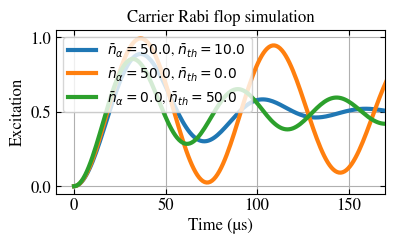

In [26]:
# Plotting
plt.figure(figsize=(4.25, 4.25 / 2))
# plt.plot(range(len(state_populations_1)), state_populations_1, color='C0', lw = 3, label=f'$\\bar{{n}}_{{\\alpha}} = {nalpha:.1f}$, $\\bar{{n}}_{{th}} = {nbar:.1f}$')
plt.plot(time, results_1, c='C0', lw=3, zorder=3, label=f'$\\bar{{n}}_{{\\alpha}} = {50:.1f}$, $\\bar{{n}}_{{th}} = {10:.1f}$')
# plt.plot(range(len(state_populations_2)), state_populations_2, color='C1', lw = 3, label=f'$\\bar{{n}}_{{\\alpha}} = {nalpha:.1f}$, $\\bar{{n}}_{{th}} = {nbar:.1f}$')
plt.plot(time, results_2, c='C1', lw=3, zorder=3, label=f'$\\bar{{n}}_{{\\alpha}} = {50:.1f}$, $\\bar{{n}}_{{th}} = {0:.1f}$')
# plt.plot(range(len(state_populations_3)), state_populations_3, color='C2', lw = 3, label=f'$\\bar{{n}}_{{\\alpha}} = {nalpha:.1f}$, $\\bar{{n}}_{{th}} = {nbar:.1f}$')
plt.plot(time, results_3, c='C2', lw=3, zorder=3, label=f'$\\bar{{n}}_{{\\alpha}} = {0:.1f}$, $\\bar{{n}}_{{th}} = {50:.1f}$')

plt.title('Carrier Rabi flop simulation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('Simulation_Carrier_Rabi.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Data processing (as npy file)

In [27]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8655
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_shuttling_full_speed", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_shuttling_full_speed", pmt_counts_avg_thresholded)

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8658
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_shuttling_half_speed", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_shuttling_half_speed", pmt_counts_avg_thresholded)

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8663
file_path = data_path + date + f"01/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_shuttling_half_speed_500us_delay", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_shuttling_half_speed_500us_delay", pmt_counts_avg_thresholded)

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8662
file_path = data_path + date + f"01/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_no_shuttling_half_speed_500us_delay", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_no_shuttling_half_speed_500us_delay", pmt_counts_avg_thresholded)

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8666
file_path = data_path + date + f"01/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_no_shuttling_half_speed_1000us_delay", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_no_shuttling_half_speed_1000us_delay", pmt_counts_avg_thresholded)

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
number = 8652
file_path = data_path + date + f"00/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_no_shuttling_half_speed_300us_delay", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_no_shuttling_half_speed_300us_delay", pmt_counts_avg_thresholded)

data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-15/"
number = 8591
file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
n_samples = 50
# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)
# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:]
np.save("./data/rabi_t_no_shuttling_half_speed_0us_delay", rabi_t)
np.save("./data/pmt_counts_avg_thresholded_no_shuttling_half_speed_0us_delay", pmt_counts_avg_thresholded)

['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


### Data fitting with shuttling

[3.36897350e-03 1.68448675e-03 8.42243375e-04 4.21121687e-04
 2.10560844e-04 1.05280422e-04 5.26402109e-05 2.63201055e-05
 1.31600527e-05 6.58002637e-06]
0.006737946999085466


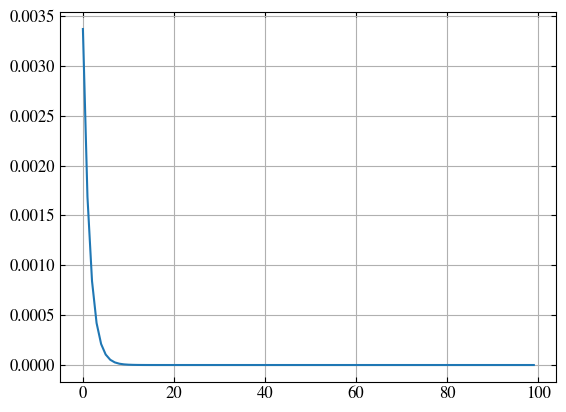

In [28]:
'''
import math

def pn_cal(nth, alpha, n_index, N):
    m_list = [i for i in range(n_index, N + 1)]
    sum_list = [(nth**m / (nth + 1)**(m+1)) * np.exp(-alpha**2) * (alpha**(2 * (- n_index + m))) / math.factorial(- n_index + m) \
                for m in m_list]
    return np.sum(sum_list)

N = 100
nth = 20
nalpha = 20
alpha = np.sqrt(nalpha)
pn_list = np.zeros(N)
for i in range(N):
    pn_list[i] = pn_cal(nth, alpha, i, N)

print(pn_list)
print(np.sum(pn_list))
'''

'''
import numpy as np
import math
from scipy.special import logsumexp, gammaln

def pn_cal(nth, alpha, n_index, N):
    m_list = np.arange(n_index, N + 1, dtype=np.float64)  # Explicitly use float64
    # Calculate the sum using logsumexp for numerical stability
    sum_list = logsumexp(m_list * np.log(nth) - (m_list + 1) * np.log(nth + 1) - alpha**2 + 2 * (m_list - n_index) * np.log(alpha) - gammaln(m_list - n_index + 1))
    return np.exp(sum_list)

N = 10000
nth = 20.0  # Use float64 implicitly
nalpha = 2.0  # Use float64 implicitly
alpha = np.sqrt(nalpha)
pn_list = np.zeros(N, dtype=np.float64)  # Explicitly use float64 for the array as well
for i in range(N):
    pn_list[i] = pn_cal(nth, alpha, i, N)

# Ensure you print only a few elements to avoid a massive output
print(pn_list[:10])  # Print the first 10 elements as an example
print(np.sum(pn_list))

'''

import numpy as np
import math
from scipy.special import logsumexp, gammaln

def pn_cal(nth, alpha, n_index, N):
    m_list = np.arange(n_index, N + 1)
    # if(n_index == 1):
    #     print(m_list)
    # Calculate the sum using logsumexp for numerical stability
    sum_list = logsumexp(m_list * np.log(nth) - (m_list + 1) * np.log(nth + 1) - alpha**2 + 2 * (np.abs(m_list - n_index)) * np.log(alpha) - gammaln(m_list - n_index + 1))
    # sum_list = logsumexp(m_list * np.log(nth) - (m_list + 1) * np.log(nth + 1) - alpha**2 + 2 * (np.abs(- m_list)) * np.log(alpha) - gammaln(m_list))
    return np.exp(sum_list)

N = 1000
nth = 1
nalpha = 10
alpha = np.sqrt(nalpha)
pn_list = np.zeros(N)
for i in range(N):
    pn_list[i] = pn_cal(nth, alpha, i, N)

# Ensure you print only a few elements to avoid a massive output
print(pn_list[:10])  # Print the first 10 elements as an example
print(np.sum(pn_list))
plt.plot(pn_list[:100])

### Re-simulate for full speed shuttling

In [29]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

# # For 1 ms data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "01"
# number = 8666

# For shuttled data
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
index = "00"
number = 8655

# # For shuttled data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "00"
# number = 8658

# File loading
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
indices_to_remove = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -18, -22]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded))) / 1.05 - 0.15    # / 0.58 - 0.28

# Running simulation
rabi = 0.065
n_ions = 6
N = 500
nbar = 3
nalpha = 60
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nalpha_values = [40, 50, 60]
results = []

for nalpha in nalpha_values:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, ndisplace_fit=complex(0, np.sqrt(nalpha)))
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_full_speed_v2.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_v2.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_full_speed_simulation_v2.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_v2.npy", results)

['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value en

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_2502/4002770408.py:15: RuntimeWarning: invalid value encountered in sqrt
  errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)


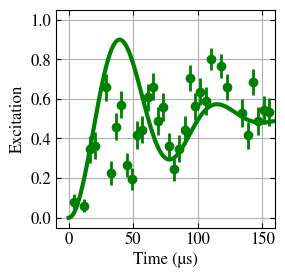

In [30]:
rabi_t = np.load("./data/save_rabi_t_shuttling_full_speed_v2.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_v2.npy")
time = np.load("./data/save_rabi_t_shuttling_full_speed_simulation_v2.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_v2.npy")

indices_to_remove = [2, 6, -7]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Plotting
factor = 1.0
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[1:] * factor, pmt_counts_avg_thresholded[1:], yerr=errorbar[1:], fmt='o', c='green', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='blue', s=30, zorder=2, label='Data')
plt.plot(time * 1, results[1], c='green', lw=3, zorder=3, label=f'$\\bar{{n}}_{{α}} = {np.average(nalpha_values):.1f} \\pm {(np.average(nalpha_values) - nalpha_values[0]):.1f}$')
# plt.plot(time * 1, results[0], '--', c='green', lw=0.5, zorder=1, alpha=0.1)
# plt.plot(time * 1, results[2], '--', c='green', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time * 1, results[0], results[2], color='green', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 160)
# plt.legend()
plt.grid(True)
plt.savefig('Rabi_9_ions_full_speed_shuttling_v2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [31]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScannThresholded_withOP'):
    file_path = data_path + date + index + f"/00000{number}-" + exp + ".h5"
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

# # For 1 ms data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "01"
# number = 8666

# For shuttled data
data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-03-16/"
index = "00"
number = 8655

# # For shuttled data
# data_path = "/Users/bingran.you/SynologyDrive/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-16/"
# index = "00"
# number = 8658

# File loading
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
indices_to_remove = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -18, -22]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded))) / 1.05 - 0.15    # / 0.58 - 0.28

# Running simulation
rabi = 0.055
n_ions = 6
N = 500
nbar = 3
nalpha = 60
def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, ndisplace_fit = complex(0, np.sqrt(nalpha))):
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nalpha_values = [40, 50, 60]
results = []

for nalpha in nalpha_values:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, ndisplace_fit=complex(0, np.sqrt(nalpha)))
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_full_speed_v3.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_v3.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_full_speed_simulation_v3.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_full_speed_simulation_v3.npy", results)

/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


['pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountered in multiply
  - (n + alpha) * _ufuncs.eval_genlaguerre(n - 1, alpha, x)) / x
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:192: RuntimeWarning: invalid value encountered in divide
  dy /= np.exp((log_dy.max() + log_dy.min()) / 2.)
/Users/bingran.you/anaconda3/envs/physics/lib/python3.11/site-packages/scipy/special/_orthogonal.py:193: RuntimeWarning: divide by zero encountered in divide
  w = 1.0 / (fm * dy)
